# Receiver Function

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/receiver_function/receiver_function.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

'Receiver functions' are a class of seismic data used to study discontinuities (layering) in the Earth's crust. At each discontinuity, P-to-S conversions occur, introducing complexity in the waveform. By deconvolving horizontal- and vertical-channel waveforms from earthquakes at teleseismic distances, we can isolate information about these conversions, and hence learn about the crustal structure. This deconvolved signal is the receiver function, and has a highly non-linear dependence on the local crustal properties.

In this notebook, we run inversion on a toy model with optimisation and parallel sampling.

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi geo-espresso

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import arviz
import multiprocessing

import cofi
import espresso

In [2]:
# randomness is used to initialise emcee walkers starting points
np.random.seed(42)

We are going to use the receiver function kernel wrapped in 
[`espresso`](https://geo-espresso.readthedocs.io/en/latest/user_guide/contrib/generated/_receiver_function/index.html),
with calls to Fortran routines developed by Takuo Shibutani in the backend.

In [3]:
my_receiver_function = espresso.ReceiverFunction(example_number=3)

Consider a model setup of `n` layers described with 3 parameters for each layer. `model` is a NumPy array of dimension `[nlayers,3]`. The values in `model[:,0]` give the depths of discontinuities in the model, while `model[:,1]` contains the S-wave speed above the interface. `model[:,2]` is the ratio of S-wave speed to P-wave speed. The maximum depth of discontinuity that can be considered is 60km.

Note that we fix the velocities of layers and the ratio of S-wave speed to P-wave speed in this example, and will only pick the 2nd and 3rd interface depths as unknowns. Here is an example Earth model we'll try to invert. 

In [4]:
null_model = my_receiver_function.starting_model
print(f"Number of model parameters in this example: {null_model.size}")
my_receiver_function._model_setup(null_model)

Number of model parameters in this example: 10


array([[10. ,  4.5,  1.7],
       [20. ,  4.5,  1.7],
       [30. ,  4.5,  2. ],
       [40. ,  4.5,  1.7],
       [50. ,  4.5,  1.7]])

Let's plot the Earth model.

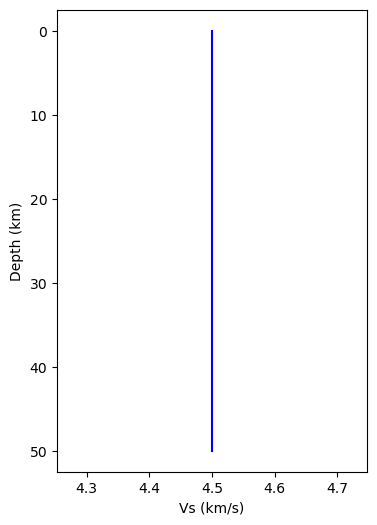

In [8]:
my_receiver_function.plot_model(null_model);

Now we calculate the receiver function and plot it

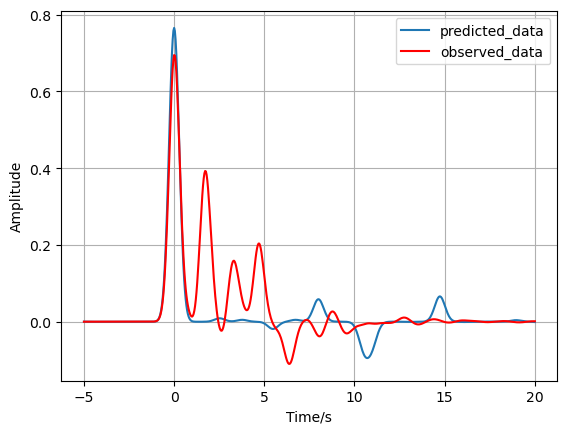

In [9]:
predicted_data = my_receiver_function.forward(null_model)
# observed_data = my_receiver_function.data
observed_data = my_receiver_function.forward(my_receiver_function.good_model)
my_receiver_function.plot_data(
    data=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 1. Define the problem

In [10]:
my_problem = cofi.BaseProblem()

In preparation for optimisation:

In [11]:
data_cov_inv = my_receiver_function.inverse_covariance_matrix * 100

def my_misfit(model, include_uncertainty=False):
    predicted_data = my_receiver_function.forward(model)
    residual = observed_data - predicted_data
    if include_uncertainty:
        return residual.T @ data_cov_inv @ residual
    else:
        return residual.T @ residual

my_problem.set_objective(my_misfit)
my_problem.set_initial_model(null_model)

In preparation for sampling:

In [17]:
def my_log_likelihood(model):
    return - my_misfit(model)

def my_log_prior(model):
    log_prior = my_receiver_function.log_prior(model)
    params_increasing = all([model[i] < model[i+2] for i in range(0,len(model)-2,2)])
    if not params_increasing:
        return float("-inf")
    return my_receiver_function.log_prior(model)

ndim = my_receiver_function.model_size

my_problem.set_model_shape(ndim)
my_problem.set_log_likelihood(my_log_likelihood)
my_problem.set_log_prior(my_log_prior)

Review what information is included in the `BaseProblem` object:

In [18]:
my_problem.summary()

Summary for inversion problem: BaseProblem
Model shape: 10
---------------------------------------------------------------------
List of functions/properties set by you:
['objective', 'log_likelihood', 'log_prior', 'initial_model', 'model_shape', 'blobs_dtype']
---------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['log_posterior', 'log_posterior_with_blobs']
---------------------------------------------------------------------
List of functions/properties that can be further set for the problem:
( not all of these may be relevant to your inversion workflow )
['log_posterior', 'log_posterior_with_blobs', 'gradient', 'hessian', 'hessian_times_vector', 'residual', 'jacobian', 'jacobian_times_vector', 'data_misfit', 'regularization', 'regularization_matrix', 'regularization_factor', 'forward', 'data', 'data_covariance', 'data_covariance_inv', 'bounds', 'constraints']


## 2. Solve with an optimiser

In [23]:
my_options_optimiser = cofi.InversionOptions()
my_options_optimiser.set_tool("scipy.optimize.minimize")
my_options_optimiser.set_params(method="Nelder-Mead")

## 2.1 Run the inversion

In [24]:
inv_optimiser = cofi.Inversion(my_problem, my_options_optimiser)
my_result_optimiser = inv_optimiser.run()
my_result_optimiser.summary()

Summary for inversion result
FAILURE
----------------------------
fun: 0.904502809047699
nit: 1357
nfev: 2000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 9.68643451,  4.20857229, 18.68923294,  5.40502562, 32.4605521 ,
         5.15420248, 32.46055314,  4.63688614, 32.96777064,  5.84015491],
       [ 9.68593581,  4.2085503 , 18.68958317,  5.40501362, 32.46035765,
         5.15417949, 32.46035879,  4.63707042, 32.96761175,  5.84011919],
       [ 9.68619333,  4.20856009, 18.689333  ,  5.40498564, 32.46081952,
         5.15418276, 32.4608192 ,  4.63695285, 32.96799066,  5.84009285],
       [ 9.6857695 ,  4.20854586, 18.68968229,  5.40499589, 32.46033574,
         5.15418653, 32.4603363 ,  4.63714151, 32.9675952 ,  5.84009752],
       [ 9.68585343,  4.2085496 , 18.6896151 ,  5.40498709, 32.46042113,
         5.15417772, 32.46042204,  4.63710927, 32.96765221,  5.84009719],
       [ 9.68591053,  4.20854972, 18.68954714,  5.40497829, 32

In [25]:
print("Inversion result:    ", my_result_optimiser.model)
print("Reference good model:", my_receiver_function.good_model)

Inversion result:     [ 9.68643451  4.20857229 18.68923294  5.40502562 32.4605521   5.15420248
 32.46055314  4.63688614 32.96777064  5.84015491]
Reference good model: [ 1.   4.   3.5  4.3  8.   4.2 20.   6.  45.   6.2]


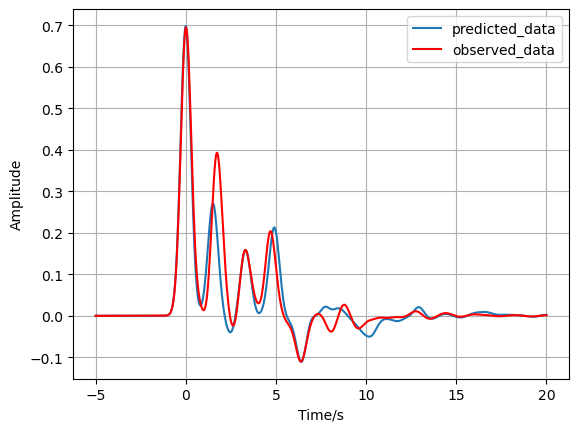

In [26]:
predicted_data = my_receiver_function.forward(my_result_optimiser.model)
my_receiver_function.plot_data(
    data=predicted_data, 
    data2=observed_data, 
    label="predicted_data", 
    label2="observed_data", 
)
plt.legend();

## 3. Solve with a sampler

In [27]:
nwalkers = 8
nsteps = 300
walkers_start = null_model + 1e-1 * np.random.randn(nwalkers, ndim)

We can run `emcee` in parallel. Some additional preparation:

In [28]:
multiprocessing.set_start_method("fork")
os.environ["OMP_NUM_THREADS"] = "1"

## 3.1 Run the inversion

In [29]:
with multiprocessing.Pool() as pool:
    my_options_sampler = cofi.InversionOptions()
    my_options_sampler.set_tool("emcee")
    my_options_sampler.set_params(
        nwalkers=nwalkers, 
        nsteps=nsteps, 
        initial_state=walkers_start,
        progress=True,
        pool=pool,
    )
    inv_sampler = cofi.Inversion(my_problem, my_options_sampler)
    inv_result_sampler = inv_sampler.run()

CofiError: error ocurred when running sampling (in the process of sampling). Check exception details from message above.

In [19]:
inv_result_sampler.summary()

Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


## 3.2 Plotting

In [20]:
az_inf_data = inv_result_sampler.to_arviz()
az_inf_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior

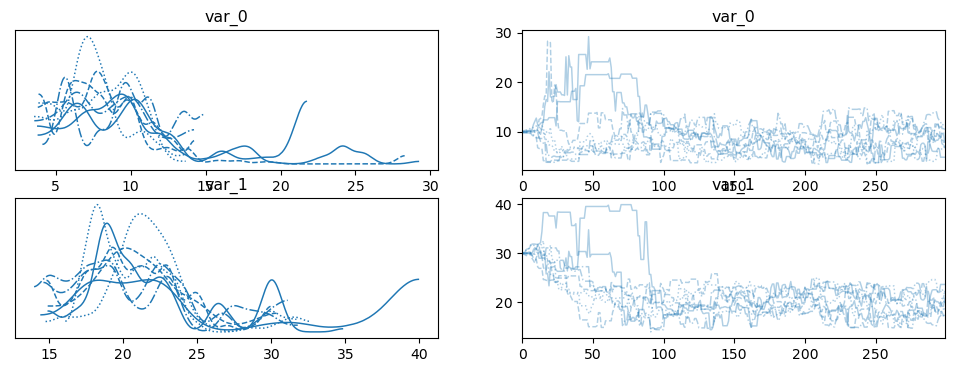

In [21]:
arviz.plot_trace(az_inf_data);

Mean of samples:      [ 8.95305125 21.602503  ]
Reference good model: [ 8. 20.]


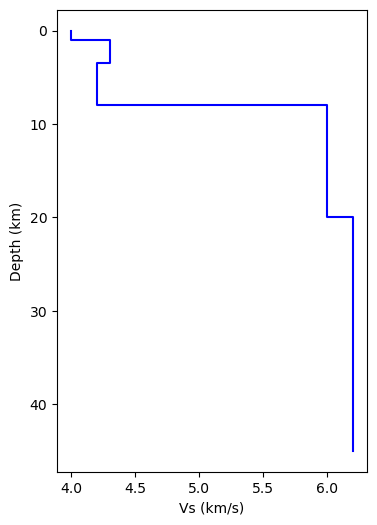

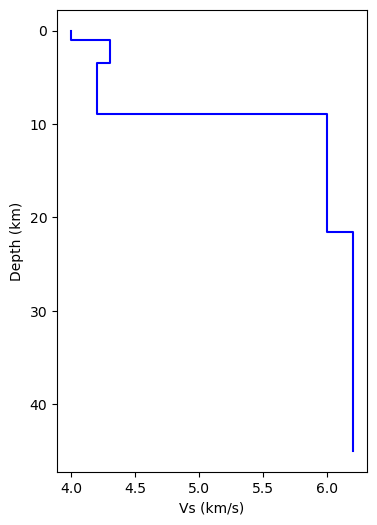

In [22]:
true_model = my_receiver_function.good_model
mean_sample = np.array(az_inf_data["posterior"].mean().to_array())

print("Mean of samples:     ", mean_sample)
print("Reference good model:", true_model)

my_receiver_function.plot_model(true_model);
my_receiver_function.plot_model(mean_sample);

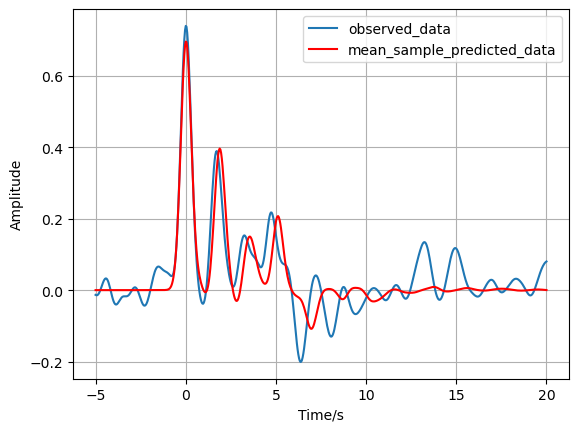

In [23]:
mean_sample_predicted_data = my_receiver_function.forward(mean_sample)
my_receiver_function.plot_data(
    observed_data, 
    mean_sample_predicted_data,
    "observed_data",
    "mean_sample_predicted_data",
);
plt.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [24]:
watermark_list = ["cofi", "espresso", "numpy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.3.dev2
espresso 0.3.4
numpy 1.23.5
matplotlib 3.5.1
emcee 3.1.4
arviz 0.15.1
